# Load Cifar10 Dataset 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# for VGG16
batch_size = 16

In [ ]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

image_size = (32, 32, 3)

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                        sampler=SubsetRandomSampler(list(range(50000))[1000:]), num_workers=2)

val_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                        sampler=SubsetRandomSampler(list(range(50000))[:1000]), num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                        sampler=SubsetRandomSampler(list(range(10000))), num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = train_set.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
train_set.data.shape , test_set.data.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

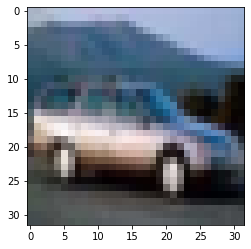

In [ ]:
i = 4
plt.imshow(train_set.data[i])

# Custom Activation Function (Clipped ReLU)




\begin{equation*}
f(x) = 
\begin{cases}
x, &\text{if $0\leq x \leq T$} \\
0, &\text{otherwise} \\
\end{cases}
\end{equation*}

In [ ]:
# create a class wrapper from PyTorch nn.Module, so
# the function now can be easily used in models
class CReLU(nn.Module):
    '''
    Applies the Clipped Relu (CReLU) function

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    References:
        -  Related paper:
        https://arxiv.org/pdf/1606.08415.pdf

    Examples:
        >>> m = CReLU()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self, T):
        super().__init__()
        self.T = torch.tensor(T)

    def forward(self, input):
        return torch.min(self.T, torch.max(torch.tensor(0), input))

# Evaluation Metric (Area Under the Accuracy vs. Normalized Fault Rate Curve (AUC))

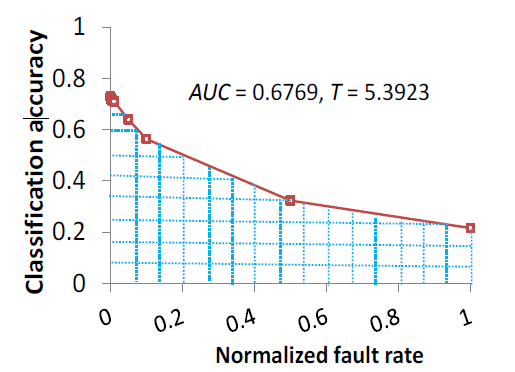

In [ ]:
# calculate above AUC
x = [0, 0.05, 0.1, 0.5, 1]
y = [0.72, 0.63, 0.59, 0.35, 0.25]
x = torch.tensor(x)
y = torch.tensor(y)
auc = torch.trapezoid(y=y, x=x)
auc ###????

tensor(0.4022)

In [ ]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [ ]:
# calculates the normalized area under 2 lists of numbers
def AUC(accs, fault_rates):
    x = torch.tensor(NormalizeData(np.array(fault_rates)))
    y = torch.tensor([i for i in accs])
    auc = torch.trapezoid(y=y, x=x)
    return auc.item()

# Ares Fault Injection Framework

[Source](https://github.com/alugupta/ares)

In [ ]:
import random
from abc import abstractmethod

In [ ]:
def get_layers(model):
    layers = list(model.named_parameters())
    nb_layers = []
    for layer in layers:
        if 'bias' not in layer[0]:
            nb_layers.append(layer)
    return nb_layers

def get_all_layers(model): 
    return list(model.named_parameters())

In [ ]:
# Generic model transformation base
class ModelTransform(object):
  def __init__(self, layer_mask=None):
    self.layer_mask = layer_mask

  @abstractmethod
  def __call__(self, model):
    return model

  @staticmethod
  def _generalize_layer_mask(model,layer_mask=None):
    # Several ways to specify which layers to transform:
    #   None: transform every layer
    #   <int>: transform only layers starting with the nth
    #   <list>: transform specific layers (must match length of model layer list)
    chosen_layers = 1+np.zeros(len(get_layers(model)),dtype='bool')
    if layer_mask is None:
      return chosen_layers
    else:
      try:
        if len(layer_mask):
          is_list = True
      except TypeError:
        is_list = False
      if is_list:
        chosen_layers = np.array(layer_mask)
      else:
        chosen_layers[0:layer_mask] = 0
    assert len(get_layers(model))==len(chosen_layers), 'Layer mask must match number of layers. ('+str(len(model.get_layers()))+' vs. '+str(len(chosen_layers))+')'
    return chosen_layers
    
  #Take a user-provided layer mask and convert to one that includes biases
  def expand_mask(self, layer_mask, skip_biases, model): 
    layers = get_all_layers(model)
    new_mask = np.zeros(len(layers),dtype='bool')
    j = 0
    for i in range(len(layers)):
        if 'bias' not in layers[i][0]:
            new_mask[i] = layer_mask[j]
            j += 1
        elif not skip_biases and j > 0:   #If skipping, ignore. If not, copy the status of previous layer
            new_mask[i] = layer_mask[j - 1]
    return new_mask
        

  def get_masked_layers(self, model, layer_mask=-1):
    if layer_mask is -1: # allow overriding the mask with a non-sentinel
      layer_mask = self.layer_mask
    mask = self._generalize_layer_mask(model, layer_mask)
    mask = self.expand_mask(mask, skip_biases, model)

    layers = get_all_layers(model)
    masked_layers = [l for l,m in zip(layers,mask) if m]
    return masked_layers

  def transform_layers(self, model, function, skip_biases, layer_mask=-1):
    if layer_mask is -1: # allow overriding the mask with a non-sentinel
      layer_mask = self.layer_mask
    mask = self._generalize_layer_mask(model, layer_mask)
    mask = self.expand_mask(mask, skip_biases, model)

    layers = get_all_layers(model)
    for l,m in zip(layers, mask):
      if m:
        v = function(l) # Must mutate the layer in-place
        assert v is None, 'Layer transform function must do their work in-place.'
    return model

  def transform_weights(self, model, function, layer_mask=-1, skip_biases=False):
    def sub_transform(layer):
      new_weights = function(layer[1].data)
      layer[1].data = new_weights
      return None # Mutation is in-place
    return self.transform_layers(model, sub_transform, skip_biases, layer_mask=layer_mask)


In [ ]:
class rng_subsys:           #Handle generation of numbers for weight and activation injections. 
                                #Can generate the exact # of expected errors per layer, or have each bit have 'thres' chance of faulting
    def __init__(self, mode, qi, qf):
        if mode == 'exact': 
            self.generate = self.gen_exact
        if mode == 'expectation':
            self.generate = self.gen_exp
        self.total_bits = qi+qf
        
    def start_gen(self, output, thres):    #Only matters for exact generation
        self.count = 0
        self.shape = output.shape
        self.device = output.device
        self.thres = thres

        if self.generate == self.gen_exact:
            self.zero = torch.zeros(1,device=output.device, dtype=torch.long)
            error_count = int(len(output) * thres * (self.total_bits))

            self.loc = torch.randint(0, len(output), [error_count], device = output.device, dtype=torch.long) #Generate the location and address for each error
            self.bit = torch.randint(0, self.total_bits, [error_count],  device = output.device)

    def gen_exact(self):
        ones = torch.ones(self.shape, device=self.device)
        bit_loc = torch.where(self.bit == self.count, self.loc, self.zero).nonzero().flatten()
        uniform = torch.zeros(self.shape, device=self.device)
        if bit_loc.nelement() > 0:
            uniform.scatter_(0, self.loc[bit_loc], ones)

        self.count += 1
        return (uniform, bit_loc.nelement() > 0)

    def gen_exp(self):
        index = torch.ones(self.shape, device=self.device)
        zero = torch.zeros(1, device=self.device)
        thres = self.thres
        while thres < 1e-5:     #The pytorch CUDA RNG does not generate numbers near 00 with uniform probability.
                                    #To work around this, product several draws where accuracy is better
            uniform = torch.rand(self.shape, device=self.device)
            index = torch.where(uniform < 1e-5, index, zero)
            thres /= 1e-5
        uniform = torch.rand(self.shape, device=self.device)
        index = torch.where(uniform < thres, index, zero)

        self.count += 1
        return (index, index.nonzero().nelement() > 0)

In [ ]:
class RandomFault(ModelTransform):
  def __init__(self, layer_mask=None, seed=0, frac=0, random_addrs=False, fault_type="uniform", int_bits=2, frac_bits=6):
    super(RandomFault,self).__init__(layer_mask)
    self.frac         = frac
    self.random_addrs = random_addrs
    self.random_seed  = seed
    self.fault_type   = fault_type
    self.int_bits = int_bits
    self.frac_bits = frac_bits
    self.total_bits = frac_bits + int_bits
    self.rng_subsys = rng_subsys('exact', int_bits, frac_bits)

  def __call__(self, model):
    def fault_wrapper(w):

        def quantize(q, v):
          (qi, qf)     = q
          (imin, imax) = (-np.exp2(qi-1), np.exp2(qi-1)-1)
          fdiv         = (np.exp2(-qf))
          v.div_(fdiv).round_().mul_(fdiv)
          v.clamp_(min=imin, max=imax)

        def bit_inject(output, thres, n_bits): 
          self.rng_subsys.start_gen(output, thres)
          qi, qf = n_bits 
          
          sign = (torch.sign(output)*2 + 1).sign()      #Grab the sign of each entry to reimpose after bit flip, by taking {-1,0,1}->{-1,1,2}->{-1,1}          

          for b in range(0,qi-1,1): #one int bit used for sign
            #generate mask of uniformly distributed random numbers
            uniform, nonzero = self.rng_subsys.generate()
            if nonzero:
                cb = 2 ** b
                # Isolate the value to be modified based on given bit position by shift and mod
                fault = output / cb
                fault.abs_().fmod_(2)
                
                #if the bit was a 1, subtract the value corresponding to that bit to flip it to 0
                #if the bit was a 0, add the value corresponding to that bit to flip it to 1
                fault = torch.where(fault < 1, torch.empty(1, device=output.device).fill_(cb), 
                    torch.empty(1, device=output.device).fill_(-cb))
                
                
                #apply flip only to 'thres' fraction of elements using generated mask
                fault *= uniform
                # return output with added flips and appropriate sign
                output += fault * sign
          
          for b in range(-1,-1*qf - 1, -1): 
            uniform, nonzero = self.rng_subsys.generate()
            if nonzero:
                cb = 2 ** b
                # Isolate the value to be modified based on given bit position by shift and mod
                fault = output / cb
                fault.abs_().fmod_(2)

                #if the bit was a 1, subtract the value corresponding to that bit to flip it to 0
                #if the bit was a 0, add the value corresponding to that bit to flip it to 1
                fault_sw = torch.where(fault < 1, torch.empty(1, device=output.device).fill_(cb), 
                    torch.empty(1, device=output.device).fill_(-cb))

                #apply flip only to 'thres' fraction of elements using generated mask
                fault_sw *= uniform

                # return output with added flips and appropriate sign
                output += fault_sw * sign
          
          #flip sign bit after other bit flips, in case a zero got hit above
          
          if qi > 0: # is there a sign bit to flip?
            uniform, nonzero = self.rng_subsys.generate()
            if nonzero:
                  sign = (output.sign() *2 + 1).sign()
                  fault = torch.where(uniform == 1, torch.empty(1, device=output.device).fill_(1 + 2 ** (self.int_bits-1)), torch.zeros(1, device=output.device))
                  fault *= sign
                  #In 2s comp (assumed for weights), sign bit flipping is equivalent to adding/subtracting the max representable val 
                  output.sub_(fault)
          

        def _inject(w):   #CONVERTED TO HERE
            addrs       = list(range(len(w)))
            if self.random_addrs:
              np.random.shuffle(addrs)

            num_faults = int(len(w) * self.total_bits * self.frac)
            #print("There are %d weights /n", len(w))
            #print("There will be %d bit flips /n", num_faults)
            # Generating random values with np.random (vectorized) is must faster
            # than python random.random
            faults = None
            if self.fault_type == "uniform":
              min_w   = np.min(w)
              max_w   = np.max(w)
              faults = np.random.uniform(min_w, max_w, num_faults)
            elif self.fault_type == "normal":
              mean, sigma = np.mean(w), np.std(w)
              faults = np.random.normal(mean, sigma, num_faults)
            elif self.fault_type == "sign":
              # -1 means flip sign, 1 means maintain sign.
              # 50% chance of flipping sign
              faults = np.random.choice([-1, 1], num_faults)
              for i in range(num_faults):
                faults[i] = faults[i] * w[i]
            elif self.fault_type == "percent":
              #-1 means increase by percent, 1 means decrease by percent
              #just set at 10% changes for now
              percent = 0.1
              faults = np.random.choice([-1,1], num_faults)
              for i in range(num_faults):
                faults[i] = w[i] * (1 + (faults[i] * percent))
            elif self.fault_type == "bit":
              # Eventually we should make sure we're not hitting the same bit.
              #  fine for now though
              bit_inject(w, self.frac, (self.int_bits, self.frac_bits))
            else:
              assert False, "Fault type: %s is invalid" % self.fault_type

            if self.fault_type == "bit":
              pass
              #print("Already updated.")
            else:
              if num_faults > 0:
                fault_addrs = addrs[:num_faults]
                for i in range(num_faults):
                  w[i] = faults[i]

            return w

      ########################################
        size = w.size()
        w = w.flatten()
        return _inject(w).view(size)
    self.transform_weights(model, fault_wrapper)


# Threshold Fine-Tuning Algorithm

In [ ]:
def model_evaluation(model, layer, T, fault_rate):
    # evaluate on the validation set
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            outputs = model(inputs, layer, T)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = correct / total
        return acc


def AUC_calculation(S_min, S_max, layer, model):
    T1 = S_min
    T2 = T1 + (S_max - S_min) / 3
    T3 = T2 + (S_max - S_min) / 3
    T4 = S_max
    Ts = [T1, T2, T3, T4]
    AUCs = []
    layer_mask = [True for layer in get_layers(model)]
    fault_rates = [1e-8, 1e-5]
    for i in range(1, 5):
        accs = []
        for fault_rate in fault_rates:
            model_temp = model
            random_fault_injector = RandomFault(layer_mask, frac=fault_rate, random_addrs=True, fault_type='bit')
            random_fault_injector(model)
            accs.append(model_evaluation(model, layer, Ts[i-1], fault_rate))
            model_temp.thresholds = model.thresholds
            model = model_temp

        AUCs.append(AUC(accs, fault_rates))
        print(f"{i}st calculated T: Accuracies: {accs}, AUC: {AUCs[-1]}")
    return Ts, AUCs

def internal_search(Ts, AUCs):
    index = np.argmax(AUCs)
    if index == 3:
        S = (Ts[2], Ts[3])
    elif index == 1:
        S = (Ts[0], Ts[1])
    else:
        S = (Ts[index-2], Ts[index])
    T = Ts[index]
    return S, T  

# for each layer of networks
def threshold_fine_tuning(N, M, delta, ACT_max, layer, model):
    counter = 1
    while counter <= N:
        print("Counter: ", counter)
        if counter == 1:
            S = (0, ACT_max)
            Ts, AUCs = AUC_calculation(S[0], S[1], layer, model)
            S, T = internal_search(Ts, AUCs)
        else:
            S, T = internal_search(Ts, AUCs)
            Ts, AUCs = AUC_calculation(S[0], S[1], layer, model)
        counter += 1
        deltas = [0, 0, 0]
        for i in [1, 2, 3]:
            deltas[i-1] = abs(AUCs[i] - AUCs[i-1])
        if max(deltas) <= delta and counter >= M:
            return T
    return T 

# VGG16

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes: int = 1000, T=math.inf):
        super(VGG16, self).__init__()
        self.thresholds = [math.inf] * 15   
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),  # Conv1
            CReLU(self.thresholds[0]),
            nn.Conv2d(64, 64, 3, padding=1),  # Conv2
            CReLU(self.thresholds[1]),
            nn.MaxPool2d(2, 2),  # Pool1
            nn.Conv2d(64, 128, 3, padding=1),  # Conv3
            CReLU(self.thresholds[2]),
            nn.Conv2d(128, 128, 3, padding=1),  # Conv4
            CReLU(self.thresholds[3]),
            nn.MaxPool2d(2, 2),  # Pool2
            nn.Conv2d(128, 256, 3, padding=1),  # Conv5
            CReLU(self.thresholds[4]),
            nn.Conv2d(256, 256, 3, padding=1),  # Conv6
            CReLU(self.thresholds[5]),
            nn.Conv2d(256, 256, 3, padding=1),  # Conv7
            CReLU(self.thresholds[6]),
            nn.MaxPool2d(2, 2),  # Pool3
            nn.Conv2d(256, 512, 3, padding=1),  # Conv8
            CReLU(self.thresholds[7]),
            nn.Conv2d(512, 512, 3, padding=1),  # Conv9
            CReLU(self.thresholds[8]),
            nn.Conv2d(512, 512, 3, padding=1),  # Conv10
            CReLU(self.thresholds[9]),
            nn.MaxPool2d(2, 2),  # Pool4
            nn.Conv2d(512, 512, 3, padding=1),  # Conv11
            CReLU(self.thresholds[10]),
            nn.Conv2d(512, 512, 3, padding=1),  # Conv12
            CReLU(self.thresholds[11]),
            nn.Conv2d(512, 512, 3, padding=1),  # Conv13
            CReLU(self.thresholds[12]),
            nn.MaxPool2d(2, 2)  # Pool5
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        # TODO: In the paper, it is mentioned that this has 1 FC, but VGG16 has 2 FC in fact :?
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            CReLU(self.thresholds[13]),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            CReLU(self.thresholds[14]),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor, layer, threshold, test=False) -> torch.Tensor:
        if not test:
            self.thresholds[layer] = threshold
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

vgg16 = VGG16()
checkpoint = 'https://download.pytorch.org/models/vgg16-397923af.pth'
vgg16.load_state_dict(torch.hub.load_state_dict_from_url(checkpoint, progress=False))
# print(vgg16)
vgg16.classifier[6] = nn.Linear(4096, 10)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
ACT_max = []
for name, param in vgg16.named_parameters():
    if "weight" in name:
        ACT_max.append(torch.max(param).item())

#print(ACT_max)

thresholds = []
accuracies = []
for layer, act in enumerate(ACT_max):
    print(f"Layer {layer}")
    #print(f"Layer {act}")
    thresholds.append(threshold_fine_tuning(1, 1, 1e-4, act, layer, vgg16))

Layer 0
Counter:  1
1st calculated T: Accuracies: [0.089, 0.09], AUC: 0.08950000256299973
2st calculated T: Accuracies: [0.091, 0.095], AUC: 0.09299999475479126
3st calculated T: Accuracies: [0.094, 0.087], AUC: 0.09049999713897705
4st calculated T: Accuracies: [0.082, 0.101], AUC: 0.09149999916553497
Layer 1
Counter:  1
1st calculated T: Accuracies: [0.1, 0.113], AUC: 0.10649999976158142
2st calculated T: Accuracies: [0.116, 0.097], AUC: 0.10649999976158142
3st calculated T: Accuracies: [0.092, 0.095], AUC: 0.09350000321865082
4st calculated T: Accuracies: [0.097, 0.085], AUC: 0.09100000560283661
Layer 2
Counter:  1
1st calculated T: Accuracies: [0.107, 0.106], AUC: 0.10649999976158142
2st calculated T: Accuracies: [0.099, 0.115], AUC: 0.10700000077486038
3st calculated T: Accuracies: [0.095, 0.095], AUC: 0.0949999988079071
4st calculated T: Accuracies: [0.102, 0.102], AUC: 0.10199999809265137
Layer 3
Counter:  1
1st calculated T: Accuracies: [0.091, 0.1], AUC: 0.09549999982118607
2st

## Evaluation

In [ ]:
def model_test_evaluation(model):
    # evaluate on the test set
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs = model(inputs, 0, 0, test=True)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = correct / total
        return acc


#model_test_evaluation(vgg16)
experiments = 1 # this should have been 50, but duo to GPU limits and time limitations changed :)
exps_p_accs = []
exps_up_accs = []





for experiment in range(experiments):
    print(f"{experiment + 1}st experiment")
    protected_acc = []
    unprotected_acc = []

    fault_rates = [1e-8, 1e-5]
    layer_mask = [True for layer in get_layers(vgg16)]

    # protected
    print("Evaluating protected network...")
    for f in fault_rates:
        model_temp = vgg16
        random_fault_injector = RandomFault(layer_mask, frac=f, random_addrs=True, fault_type='bit')
        random_fault_injector(vgg16)
        exps_p_accs.append(model_test_evaluation(vgg16))
        model_temp.thresholds = vgg16.thresholds
        vgg16 = model_temp
        print(f"\t\tFault rate = {f} Done !")
    
    exps_p_accs.append(protected_acc)

    # unprotected
    print("Evaluating unprotected network...")
    vgg16.thresholds = [math.inf] * 15 
    for f in fault_rates:
        model_temp = vgg16
        random_fault_injector = RandomFault(layer_mask, frac=f, random_addrs=True, fault_type='bit')
        random_fault_injector(vgg16)
        exps_up_accs.append(model_test_evaluation(vgg16))
        model_temp.thresholds = vgg16.thresholds
        vgg16 = model_temp
        print(f"\t\tFault rate = {f} Done !")

    exps_up_accs.append(unprotected_acc)


SyntaxError: ignored

In [ ]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(15)
fig.set_figheight(5)


# plt.setp(axes, xticks=fault_rates, xticklabels=fault_rates)

axes[0].plot(fault_rates, np.mean(exps_p_accs, axis=0), color="r", label="Resilient DNN using the proposed methodology")
axes[0].plot(fault_rates, np.mean(exps_up_accs, axis=0), color="b", label="Unprotected DNN")
axes[0].set_xlabel("Fault rate")
axes[0].set_ylabel("Classification accuracy")
axes[0].legend()

axes[1].boxplot(np.array(exps_p_accs).T.tolist())
axes[1].set_xlabel("Fault rate")
axes[1].set_ylabel("Classification accuracy")
axes[1].set_title("Protected Network")
    
axes[2].boxplot(np.array(exps_up_accs).T.tolist())
axes[2].set_xlabel("Fault rate")
axes[2].set_ylabel("Classification accuracy")
axes[2].set_title("UNProtected Network")

fig.tight_layout()
